# **AML Project : Raman Spectroscopy**

## Import libraries

In [1]:
import os, glob, re
from google.colab import drive
from sklearn.datasets import load_files

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

from sklearn import decomposition, tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import random

## Extract data from google colab

In [2]:
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + 'Raman_Data/'
als_dir = base_dir + 'ALS/'
ctrl_dir = base_dir + 'CTRL/'

Mounted at /content/drive


### Get als and ctrl files from directories

In [3]:
all_files_als = os.listdir(als_dir)
print(len(all_files_als))
all_files_ctrl = os.listdir(ctrl_dir)
print(len(all_files_ctrl))

393
198


### Sort the files by ascending order

In [4]:
all_files_als.sort(key=lambda f: int(re.sub('\D', '', f)))
all_files_ctrl.sort(key=lambda f: int(re.sub('\D', '', f)))

In [5]:
#print(all_files_als[226]) -> 227 missing

## Utility function to parse files


In [6]:
def parse_text(file, dir):
  with open(dir + file, 'rt') as fd:
    data=[]
    line = fd.readline()
    nline = re.findall(r"[-+]?\d*\.\d+|\d+", line)
    data.append(nline)
    while line:
      line=fd.readline()
      nline = re.findall(r"[-+]?\d*\.\d+|\d+", line)
      data.append(nline)
  return data

## Create X and Y 



*   **X** corresponds to the y coordinates of the spectra
*   **Y** corresponds to the class of the spectra ie 0 -> CTRL and 1 -> ALS
*   **coord** corresponds to the x coordinates of the spectra (in order to plot some of them later on)
*   **groups** contains the corresponding index of the patients' spectra ie patient1 -> 0, patient2 -> 1 ... patient30 -> 29.
*   **sep** is a list with the last spectrum number (cumulated)




In [7]:
X=[] #actual y of spectra
Y=[] # 1 -> als; 0 -> ctrl
coord=[] #actual x of spectra

sep=[60,78,114,150,194,210,225,241,255,280,299,313,323,333,343,353,363,373,383,393] #Il manque le 227
groups=[] #for GROUP K FOLD
group=0
index=1
for f in all_files_als:
  data=[]
  datab=[]
  for e in parse_text(f, als_dir):
    if len(e) > 0:
      datab.append(float(e[0]))
      data.append(float(e[1]))
  coord.append(datab)
  X.append(data)
  Y.append(1)
  groups.append(group)
  if index in sep:
    group+=1
  index+=1

In [8]:
#print(len(X))
sep=[33,76,91,138,149,158,168,178,188,198]
index=1
for f in all_files_ctrl:
  data=[]
  datab=[]
  for e in parse_text(f, ctrl_dir):
    if len(e) > 0:
      datab.append(float(e[0]))
      data.append(float(e[1]))
  coord.append(datab)
  X.append(data)
  Y.append(0)
  groups.append(group)
  if index in sep:
    group+=1
  index+=1

### Transform data in np array for preprocessing

In [53]:
X=np.array(X)
Y=np.array(Y)
groups=np.array(groups)
print(X.shape, Y.shape)

(591, 1174) (591,)


## Plot spectra

Plotting some spectra in order to have a look

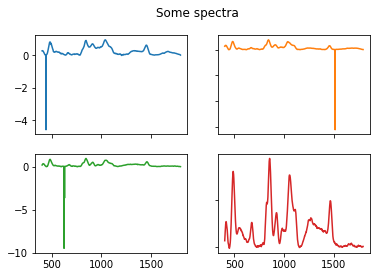

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Some spectra')
ax1.plot(coord[5], X[5])
ax2.plot(coord[80], X[80], 'tab:orange')
ax3.plot(coord[78], X[78], 'tab:green')
ax4.plot(coord[500], X[500], 'tab:red')


for ax in fig.get_axes():
    ax.label_outer()

## Feature Extraction With PCA

### Strandardize features

In [11]:
# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the features and transform
X_std = sc.fit_transform(X)

### PCA in action

**n_component** need to be tuned

In [12]:
# Create a pca object with the 2 components as a parameter
pca = decomposition.PCA(n_components=500)

# Fit the PCA and transform the data
X_std_pca = pca.fit_transform(X_std)
print(X_std_pca.shape)

(591, 500)


## Train test split the data (K-fold)


GroupKFold because data have correlations within groups => NGroupKFold chosen

In [13]:
group_kfold = GroupKFold(n_splits=8)
def data_split(X):
  group_kfold.get_n_splits(X, Y, groups)
  for train_index, test_index in group_kfold.split(X, Y, groups):
      #print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = Y[train_index], Y[test_index]
      #print(X_train, X_test, y_train, y_test)
  return X_train, X_test, y_train, y_test

In [14]:
X_train_b, X_test_b, y_train_b, y_test_b = data_split(X)

In [15]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = data_split(X_std_pca)

## Train test split data (LeaveOneGroupOut)

In [16]:
logo = LeaveOneGroupOut()
logo.get_n_splits(X_std_pca, Y, groups)
logo.get_n_splits(groups=groups)
for train_index, test_index in logo.split(X_std_pca, Y, groups):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_logo, X_test_logo = X_std_pca[train_index], X_std_pca[test_index]
    y_train_logo, y_test_logo = Y[train_index], Y[test_index]
    print(X_train_logo, X_test_logo, y_train_logo, y_test_logo)

TRAIN: [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304

## Classical classifier models

### Decision Tree Classifier

In [17]:
def decision_tree(X_train, X_test, y_train):
  clf = tree.DecisionTreeClassifier() 
  clf = clf.fit(X_train, y_train)
  return clf.predict(X_test)

preds_b = decision_tree(X_train_b, X_test_b, y_train_b)
preds_pca = decision_tree(X_train_pca, X_test_pca, y_train_pca)
preds_logo = decision_tree(X_train_logo, X_test_logo, y_train_logo)

print("Predictions base", preds_b)
print("\nAccuracy score base", accuracy_score(y_test_b, preds_b))
print("\n",classification_report(y_test_b, preds_b, labels=[0, 1]))
# optional : tree.plot_tree(clf) 

print("Predictions PCA", preds_pca)
print("\nAccuracy score PCA", accuracy_score(y_test_pca, preds_pca))
print("\n",classification_report(y_test_pca, preds_pca, labels=[0, 1]))

print("Predictions LOGO", preds_logo)
print("\nAccuracy score LOGO", accuracy_score(y_test_logo, preds_logo))
print("\n",classification_report(y_test_logo, preds_logo, labels=[0, 1]))

Predictions base [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0
 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0
 0 0 0 1]

Accuracy score base 0.782051282051282

               precision    recall  f1-score   support

           0       0.32      0.60      0.41        10
           1       0.93      0.81      0.87        68

    accuracy                           0.78        78
   macro avg       0.62      0.70      0.64        78
weighted avg       0.85      0.78      0.81        78

Predictions PCA [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0
 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0]

Accuracy score PCA 0.8974358974358975

               precision    recall  f1-score   support

           0       0.56      1.00      0.71        10
           1       1.00      0.88      0.94        68

    accuracy                           0.90        78
   macro avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CROSS VALIDATION SCORE (?)

In [18]:
clf = tree.DecisionTreeClassifier() 
scores = cross_val_score(clf, X_train_pca, y_train_pca, cv=5)
print(scores)

[0.7961165  0.66019417 0.91262136 0.3627451  0.80392157]


### Logistic Regression

In [19]:
def logistic(X_train, y_train, X_test):
  clf = LogisticRegression(random_state=0).fit(X_train, y_train)
  return clf.predict(X_test)

preds_b = logistic(X_train_b, y_train_b, X_test_b)
preds_pca = logistic(X_train_pca, y_train_pca, X_test_pca)
preds_logo = logistic(X_train_logo, y_train_logo, X_test_logo)

print("Predictions of Logistic Regression on base :", preds_b)
print("Accuracy obtained on base:", accuracy_score(y_test_b, preds_b))
print(classification_report(y_test_b, preds_b, labels=[0, 1]))

print("Predictions of Logistic Regression on PCA :", preds_pca)
print("Accuracy obtained on PCA:", accuracy_score(y_test_pca, preds_pca))
print(classification_report(y_test_pca, preds_pca, labels=[0, 1]))

print("Predictions of Logistic Regression on LOGO", preds_logo)
print("\nAccuracy score LOGO", accuracy_score(y_test_logo, preds_logo))
print("\n",classification_report(y_test_logo, preds_logo, labels=[0, 1]))

Predictions of Logistic Regression on base : [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0]
Accuracy obtained on base: 0.6025641025641025
              precision    recall  f1-score   support

           0       0.24      1.00      0.39        10
           1       1.00      0.54      0.70        68

    accuracy                           0.60        78
   macro avg       0.62      0.77      0.55        78
weighted avg       0.90      0.60      0.66        78

Predictions of Logistic Regression on PCA : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0]
Accuracy obtained on PCA: 0.5769230769230769
              precision    recall  f1-score   support

           0       0.23      1.00      0.38        10
           1       1.00      0.51      0.68        68

    accur

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


## Some better models

### SVM

In [20]:
def svm(X_train, y_train, X_test):
  clf = make_pipeline(SVC(gamma='auto')) #StandardScaler(), 
  clf.fit(X_train, y_train)
  return clf.predict(X_test)

preds_b = svm(X_train_b, y_train_b, X_test_b)
print(accuracy_score(y_test_b, preds_b))


preds_pca = svm(X_train_pca, y_train_pca, X_test_pca)
print(accuracy_score(y_test_pca, preds_pca))

preds_logo = svm(X_train_logo, y_train_logo, X_test_logo)
print(accuracy_score(y_test_logo, preds_logo))

0.7564102564102564
0.6794871794871795
0.8


### Random Forests

In [60]:
def random_forest(X_train, y_train, X_test):
  clf = RandomForestClassifier(max_depth=100, random_state=0)
  clf.fit(X_train, y_train)
  return clf.predict(X_test)

In [61]:
preds_b = random_forest(X_train_b, y_train_b, X_test_b)
print(accuracy_score(y_test_b, preds_b))

preds_pca = random_forest(X_train_pca, y_train_pca, X_test_pca)
print(accuracy_score(y_test_pca, preds_pca))

preds_logo = random_forest(X_train_logo, y_train_logo, X_test_logo)
print(accuracy_score(y_test_logo, preds_logo))

0.6025641025641025
0.8717948717948718
0.4
